In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Dataset : oxford dataset

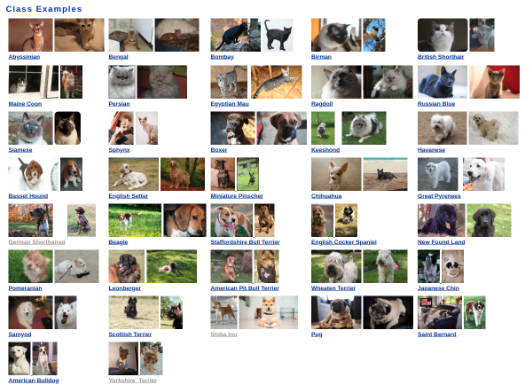

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/08/oxf.png')

* Download

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
print(dataset.keys())
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP2BT8W/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteP2BT8W/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
dict_keys(['train', 'test'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1

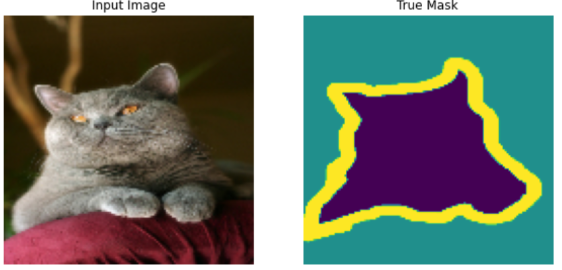

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/08/data.png')

1) class 1 : 애완동물이 속한 픽셀<br>
2) class 2 : 애완동물과 인접한 가까운 픽셀<br>
3) class 3 : 1, 2에 속하지 않는 픽셀

* Data Preprocessing

In [ ]:
def random_flip(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        # 이미지를 확률적으로 왼쪽에서 오른쪽으로 뒤집기
    
    return input_image, input_mask
 
def normalize(input_image, input_mask):

    input_image = tf.cast(input_image, tf.float32) / 255.0
    # norm
    input_mask -= 1
    # 1,2,3 → 0,1,2
    return input_image, input_mask
    # 정규화
 
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    # 이미지 사이즈 조정, 주변값을 이용하여 채우기
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    # random하게 뒤집기
    input_image, input_mask = normalize(input_image, input_mask)
    # 정규화 적용
 
    return input_image, input_mask
 
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    # test이기에 위와 동일하게 하되 뒤집기와 정규화 생략
 
    return input_image, input_mask

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# 각각의 데이터에 위에서 구현한 이미지 전처리 함수 적용, 병렬처리
test = dataset['test'].map(load_image_test)
# 테스트 데이터에 대해서도 동일하게 적용

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
 
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# dataset을 섞어서 batch로 구성
 
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# 다음 step의 데이터가 잘 대기할 수 있도록 구성

test_dataset = test.batch(BATCH_SIZE)
# batch로 구성

In [ ]:
class_names = ['pet', 'background', 'outline']
# segment의 class 

def display(display_list, titles=[], display_string=None):
  # 아래의 class name, iou, dice_score를 입력
    plt.figure(figsize=(15,15))
 
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    
    plt.show() 
    # 이미지 시각화

def display_with_metrics(display_list, iou_list, dice_score_list):
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list))]
    # index와 iou, dice_score
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)
    # iou를 기준으로 정렬
 
    display_string_list = [f"{class_names[idx]}: IoU: {iou} Dice Score: {dice_score}" for idx, iou, dice_score in metrics_by_id]
    # class의 이름과 iou, dice_score list
    display_string = "\n\n".join(display_string_list)
    # 줄바꿈
    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)
    # 시각화 하는데, image, 예측 mask, true mask 순서로 한다. 

In [ ]:
def show_image_from_dataset(dataset):
  # 데이터 셋을 입력으로 받으면
    for image, mask in dataset.take(1):
      # 데이터 하나 가져와서
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=['Image', 'True Maks'])
    # 시각화 

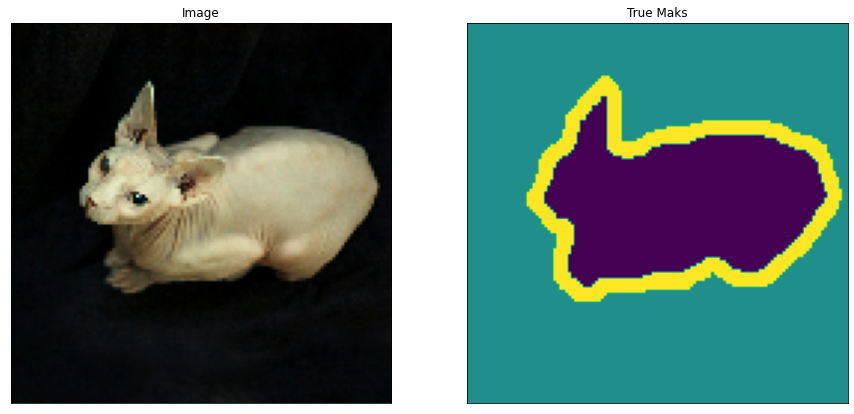

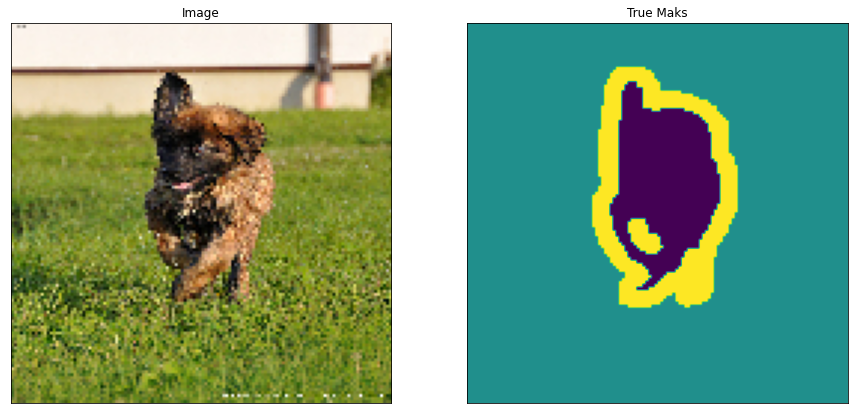

In [ ]:
show_image_from_dataset(train)
# train에서 한장 가져오기 

show_image_from_dataset(test)
# test에서 한장 가져오기

* Model

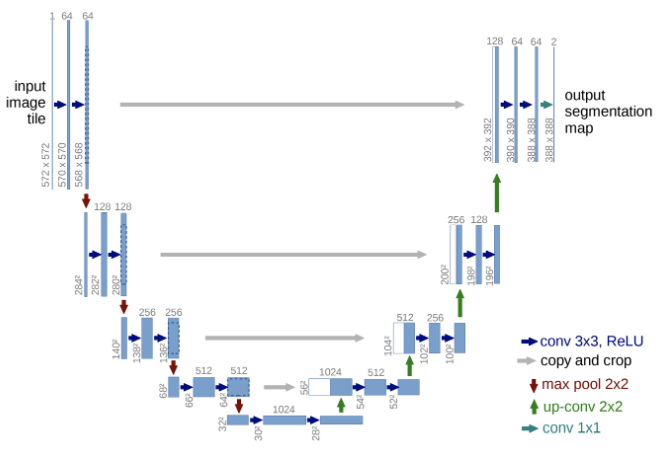

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/08/Unet1.png')

* Encoder

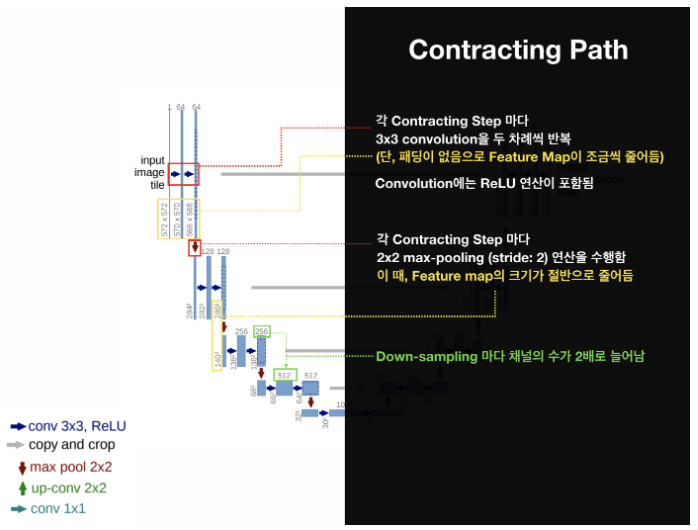

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/08/enc.png')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
 
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                                   kernel_initializer='he_normal', activation='relu', padding='same')(x)
    return x
    # convolution block 2번 반복
 
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
 
    f = conv2d_block(inputs, n_filters)
    # 위에서 정의한 conv 2번하는 함수
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    # pool 1/2
    p = tf.keras.layers.Dropout(dropout)(p)

    return f, p
    # feature map, pooling map
    # 한번의 conv step
    # f는 건너편에 더해줄 출력, p는 아래로 내려가는 출력
    
def encoder(inputs):
    
    f1, p1 = encoder_block(inputs, n_filters=64)
    # 첫번째 conv2번 (padding) → pooling (1/2)
    f2, p2 = encoder_block(p1, n_filters=128)
    # 두번째 
    f3, p3 = encoder_block(p2, n_filters=256)
    # 세번째
    f4, p4 = encoder_block(p3, n_filters=512)
    # 네번째
 
    return p4, (f1, f2, f3, f4)

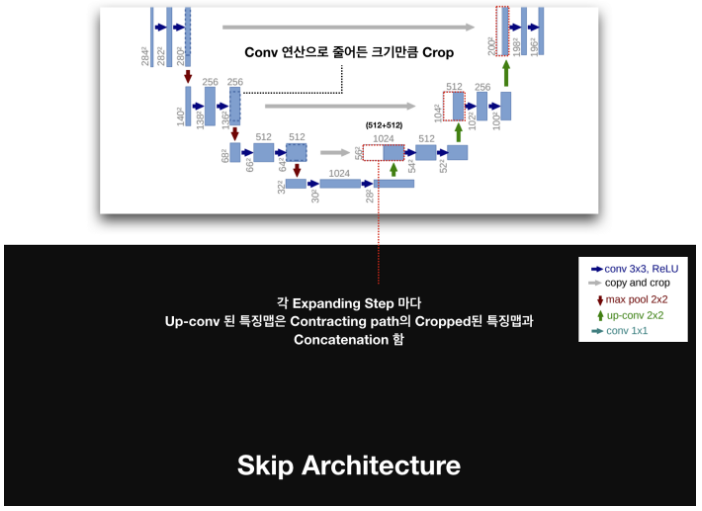

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/08/skip.png')

In [ ]:
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck
    # 맨 아래 layer

* Decoder

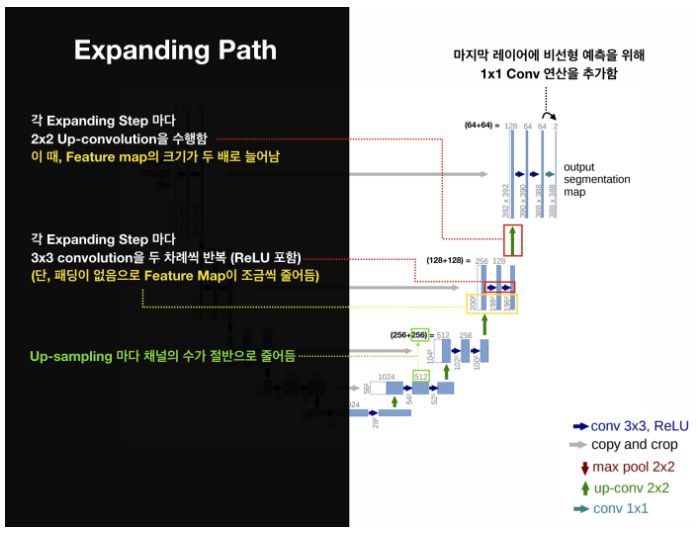

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/08/dec.png')

In [ ]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
 
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    # 건너편 encoder에서 대비되는 feature map과 concat 연산
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters)
 
    return c
 
def decoder(inputs, convs, output_channels):
 
    f1, f2, f3, f4 = convs
 
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=3, strides=2)
    # conv 역 연산 하면서 conv에서 나온 대응되는 feature map 더하기
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=3, strides=2)
    # 반복
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=3, strides=2)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=3, strides=2)
 
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(c9)
    # encoder와 반대로 구성
    return outputs

In [ ]:
OUTPUT_CHANNELS = 3
 
def UNet():
 
    inputs = tf.keras.layers.Input(shape=(128,128,3,))
 
    encoder_output, convs = encoder(inputs)
    # encoder
    bottle_neck = bottleneck(encoder_output)
    # bottle_neck
    outputs = decoder(bottle_neck, convs, OUTPUT_CHANNELS)
    # decoder
    # 건너편 encoder의 feature map 가져와서 concat
 
    model = tf.keras.Model(inputs, outputs)
 
    return model
 
model = UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d_8[0][0]']               
                                )                                                             

* Optimizer

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              # int와 loss 계산.
              metrics=['acc'])

* 저장하면서 훈련하기

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
!mkdir weights_unet

In [ ]:
 # mcp = ModelCheckpoint(filepath='weights_unet/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
  #                       save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch', verbose=1)

* Train

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
# dataset에서 train가져와서 길이
EPOCHS = 5
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
 
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset) # , callbacks=[mcp])

Epoch 1/5
57/57 [==============================] - 51s 516ms/step - loss: 0.9306 - acc: 0.5758 - val_loss: 0.8919 - val_acc: 0.5736
Epoch 2/5
57/57 [==============================] - 30s 500ms/step - loss: 0.7655 - acc: 0.6662 - val_loss: 0.6828 - val_acc: 0.7239
Epoch 3/5
57/57 [==============================] - 28s 492ms/step - loss: 0.6379 - acc: 0.7448 - val_loss: 0.6299 - val_acc: 0.7532
Epoch 4/5
57/57 [==============================] - 28s 493ms/step - loss: 0.5602 - acc: 0.7811 - val_loss: 0.5271 - val_acc: 0.7935
Epoch 5/5
57/57 [==============================] - 28s 493ms/step - loss: 0.5682 - acc: 0.7761 - val_loss: 0.5062 - val_acc: 0.8022


* 학습 내용 시각화 : 5번 학습하였기에 아직 최고 성능까지 학습이 되지는 않는다.

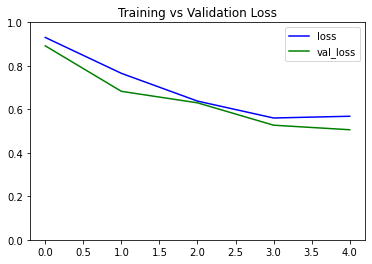

In [ ]:
def plot_metrics(model_history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name], 'b', label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], 'g', label='val_'+metric_name)
    plt.legend()
    
plot_metrics(model_history, "loss", title="Training vs Validation Loss", ylim=1)
# 학습 결과 확인

* 20 epoch 사전에 학습한 가중치

In [ ]:
model.load_weights('/content/drive/MyDrive/CDS2(2022-2)/weight/unet_weight/weights.17-0.31.hdf5')

* 예측하는 단계까지 필요한 함수

In [ ]:
def get_test_image_and_annotation_arrays():
# 이미지, mask 나머지 갯수 조정해서 정해진 갯수만 출력해주는 함수
    ds = test_dataset.unbatch()
    # test data batch에서 떼기
    ds = ds.batch(info.splits['test'].num_examples)
    # example 갯수만큼 가져오기
 
    images = []
    y_true_segments = []
 
    for image, annotation in ds.take(1):
      # 데이터셋 하나를 가져와서
        y_true_segments = annotation.numpy()
        images = image.numpy()
        # 각각 segment와 image numpy 형식으로 변경

    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
    # batch로 연산하고 나머지 부분은 제외
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

In [ ]:
def create_mask(pred_mask):

    pred_mask = tf.argmax(pred_mask, axis=-1)
    # 가장 큰 값
    pred_mask = pred_mask[..., tf.newaxis]
    # 사이즈 변경
    return pred_mask[0].numpy()
    # 마스크중 하나를 numpy로 변환
# 예측하고 차원늘려서 numpy변환하는 함수

In [ ]:
def make_predictions(image, mask, num=1):
    
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    # 이미지 사이즈를 조정
    pred_mask = model.predict(image)
    # 모델에 입력하여 예측 마스크 출력
    pred_mask = create_mask(pred_mask)
    # 예측 마스크를 위의 함수에 넣어서 재 출력
    return pred_mask

In [ ]:
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []
 
    smoothening_factor = 0.00001
    
    for i in range(3):
        intersection = np.sum((y_pred==i) * (y_true==i))
        # 교집합
        y_true_area = np.sum((y_true==i))
        # 실제 영역
        y_pred_area = np.sum((y_pred==i))
        # 예측 영역
        combined_area = y_true_area + y_pred_area
        # 합집합
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
    
    return class_wise_iou, class_wise_dice_score
    # iou, dice_score 계산

* 결과 예측

In [ ]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
# 이미지와 마스크 출력

results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
# test 입력하여 결촤 예측

In [ ]:
results = np.argmax(results, axis=3)

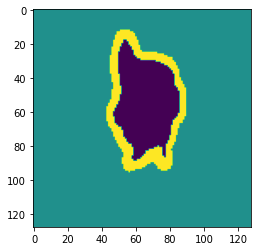

In [ ]:
plt.imshow(results[0])

In [ ]:
results = results[..., tf.newaxis]

* IoU, Dice_score

In [ ]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)
# iou, dice_score

In [ ]:
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 
    # class별 iou

pet         0.7744331885202964 
background  0.8737442985628996 
outline     0.45004063444298414 


In [ ]:
for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score))
    # class별 dice_score

pet         0.8728795127714031 
background  0.9326185000089496 
outline     0.6207283075432001 


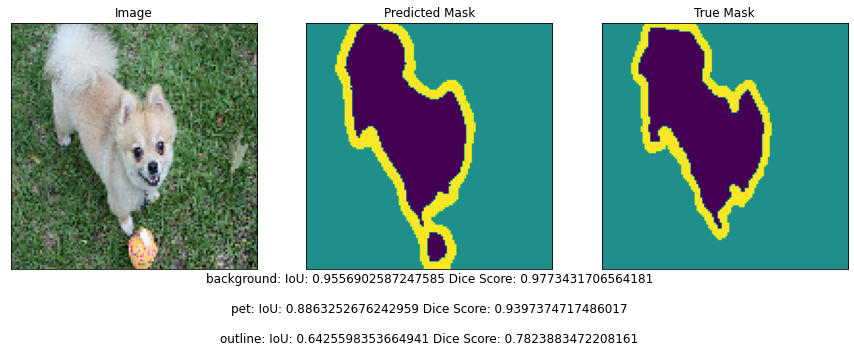

In [ ]:
integer_slider = 2555

y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
# 예측마스크 
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  
# iou, dice_score
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)
# 이미지 시각화

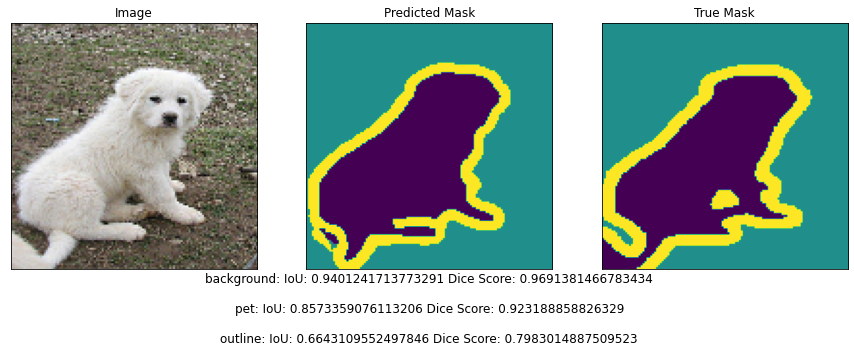

In [ ]:
integer_slider = 2500

y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
# 예측마스크 
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  
# iou, dice_score
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)
# 이미지 시각화